# 读取数据

In [4]:
import pickle
node_dict_amap={}
node_dict={}
road_edges={}
orthogonal_list={}
road_zip={}
# road_dict={}
with open('../data/map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('../data/map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('../data/road_edges.pkl','rb') as f:
    road_edges=pickle.load(f)
with open('../data/graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('../data/road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)

    
class edge_item:
    def __init__(self,vi,vj):
        self.position=(vi,vj)
        self.exist=False
        self.rname=''
        self.roads=[]    
adj_matrix={vi:{vj:edge_item(vi,vj) for vj in orthogonal_list} for vi in orthogonal_list}
for key,value in orthogonal_list.items():
    vi=key
    edges=value[0]+value[1]
    for edge in edges:
        vj=edge[1]
        adj_matrix[vi][vj].exist=True
        adj_matrix[vi][vj].rname=edge[0]

# 相似度分析
## 时间相似度

In [ ]:
import random
import math
import numpy as np
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

def fast_DTW(s1, s2, T=5):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(i-T-1,i+T+2):
            if j<0 or j>=len(s2):
                continue
            if math.fabs(i-j)<=T:
                dist= (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)],DTW[(i-1, j-1)])
            else:
                DTW[(i, j)]=float('inf')
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
data=data.swapaxes(0,1)#date,road,time,regular_speed
data=np.concatenate(data,axis=1)#road,datetime,regular_speed
resemble_matrix=[[0 for i in range(len(data))] for j in range(len(data))]
bar = ProgressBar(widgets=widgets, maxval=len(data)*len(data)).start()
for i in range(len(data)):
    for j in range(i,len(data)):
        # resemble_matrix[i][j]=random.randint(0, 10)
        resemble_matrix[i][j]=fast_DTW(data[i],data[j])
        bar.update(i*len(data)+j+1)
bar.finish()

#保存矩阵
import pickle
with open('../data/resemble_matrix.pkl','wb') as f:
    pickle.dump(resemble_matrix, f)

IOPub message rate exceeded.ed Time: 5:16:52 ETA:  2 days, 10:21:18  11.81  B/s
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.sed Time: 8:49:41 ETA:  2 days, 5:09:16  12.13  B/s
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.ed Time: 12:12:32 ETA:  1 day, 23:26:00  12.60  B/s
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

# 读取矩阵

In [8]:
import pickle
import numpy as np
resemble_matrix={}
with open('../data/resemble_matrix.pkl','rb') as f:
    resemble_matrix=pickle.load(f)

for i in range(len(resemble_matrix)):
    for j in range(i,len(resemble_matrix[i])):
        resemble_matrix[j][i]=resemble_matrix[i][j]
resemble_matrix=np.array(resemble_matrix)
resemble_matrix=(resemble_matrix-resemble_matrix.min())/(resemble_matrix.max()-resemble_matrix.min())

# 绘制矩阵

In [17]:
#绘制矩阵
import cv2 as cv
sample=np.array(resemble_matrix)
sample=255.0*sample
cv.imwrite("../img/resemble_matrix.png", sample)

True

# 聚类分析

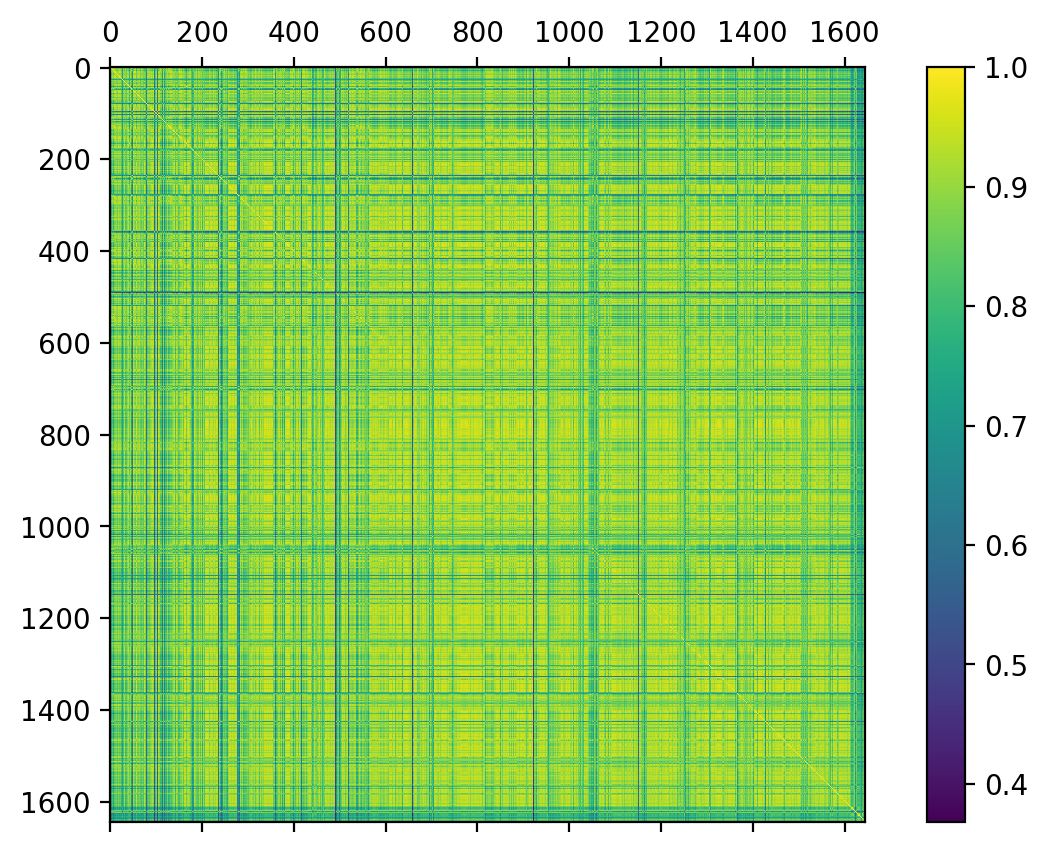

In [9]:
import math
affinity_matrix=[[0 for i in range(len(resemble_matrix))] for j in range(len(resemble_matrix))]
for i in range(len(resemble_matrix)):
    for j in range(i,len(resemble_matrix)):
        affinity_matrix[i][j]=math.exp(-resemble_matrix[i][j])
        affinity_matrix[j][i]=affinity_matrix[i][j]
# 绘制矩阵            
import matplotlib.pyplot as plt
from matplotlib import cm,colors
minium,maxium=min(np.array(affinity_matrix).flatten()),max(np.array(affinity_matrix).flatten())
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.matshow(affinity_matrix,cmap='viridis')
norm = colors.Normalize(vmin=minium, vmax=maxium)
im = cm.ScalarMappable(norm=norm, cmap='viridis')
fig.colorbar(im,ax=ax) 
fig.show()

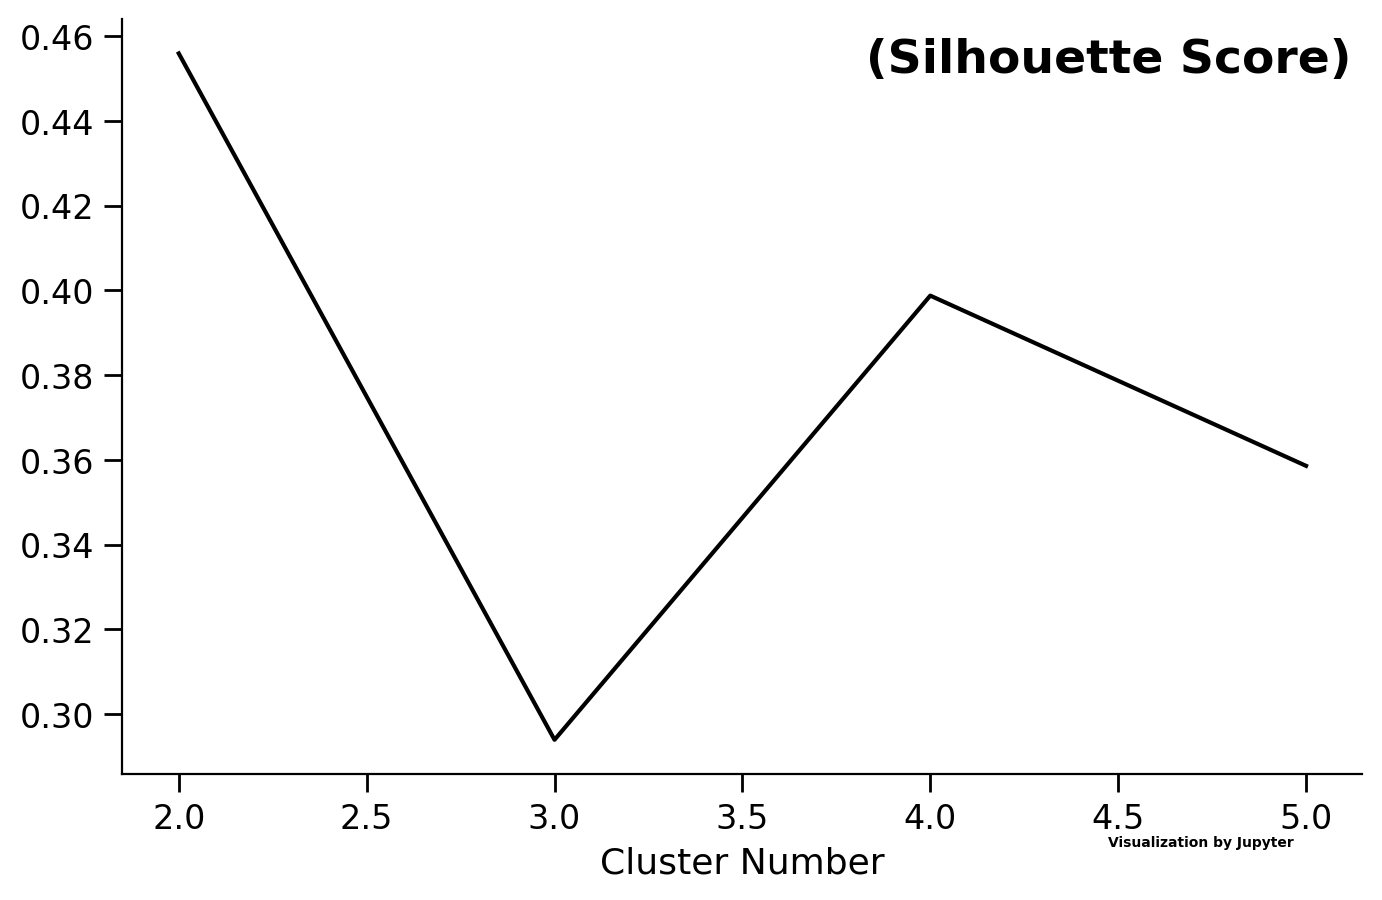

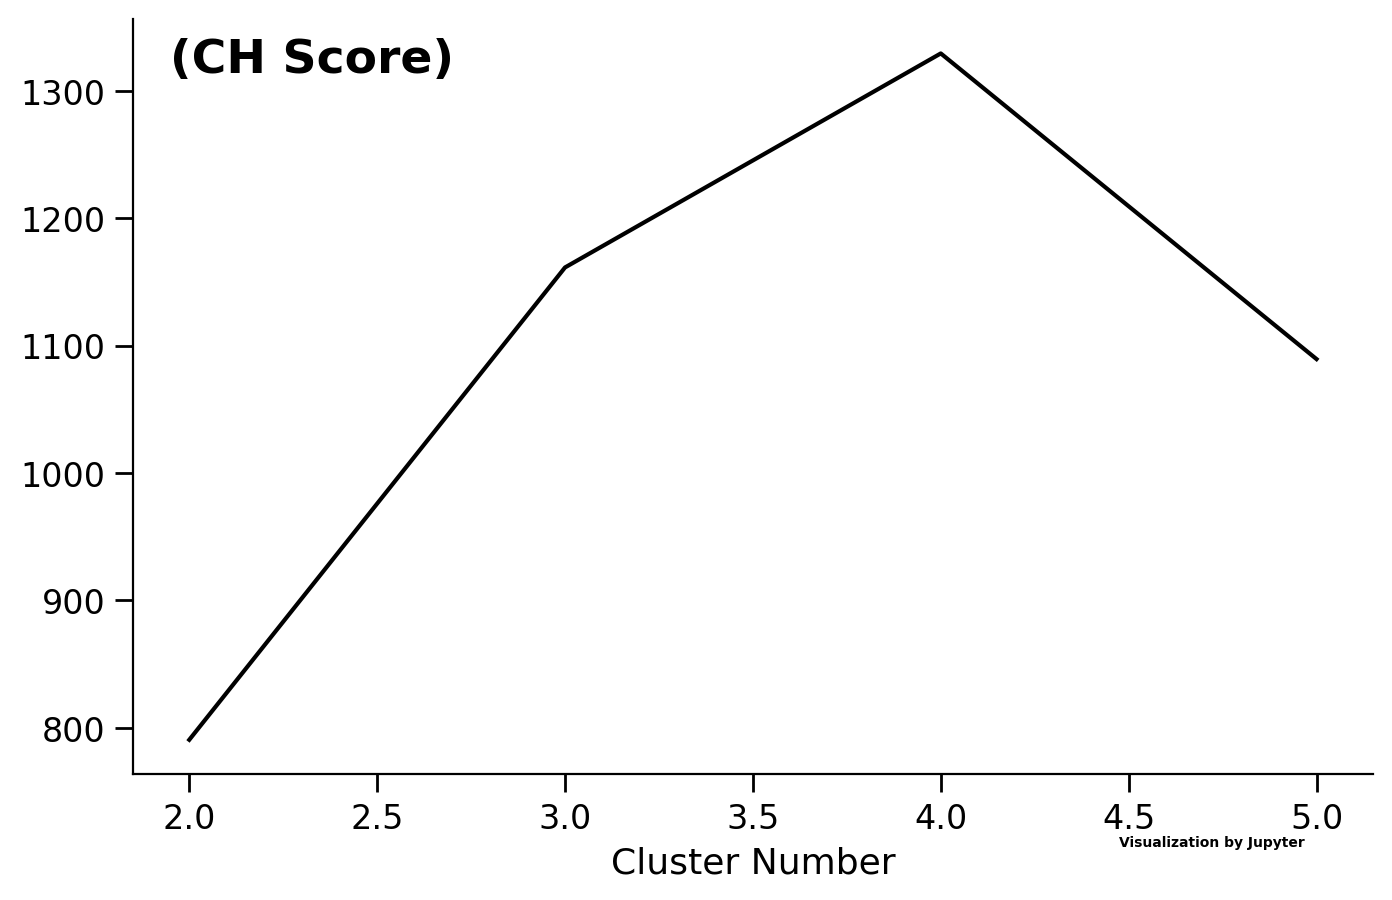

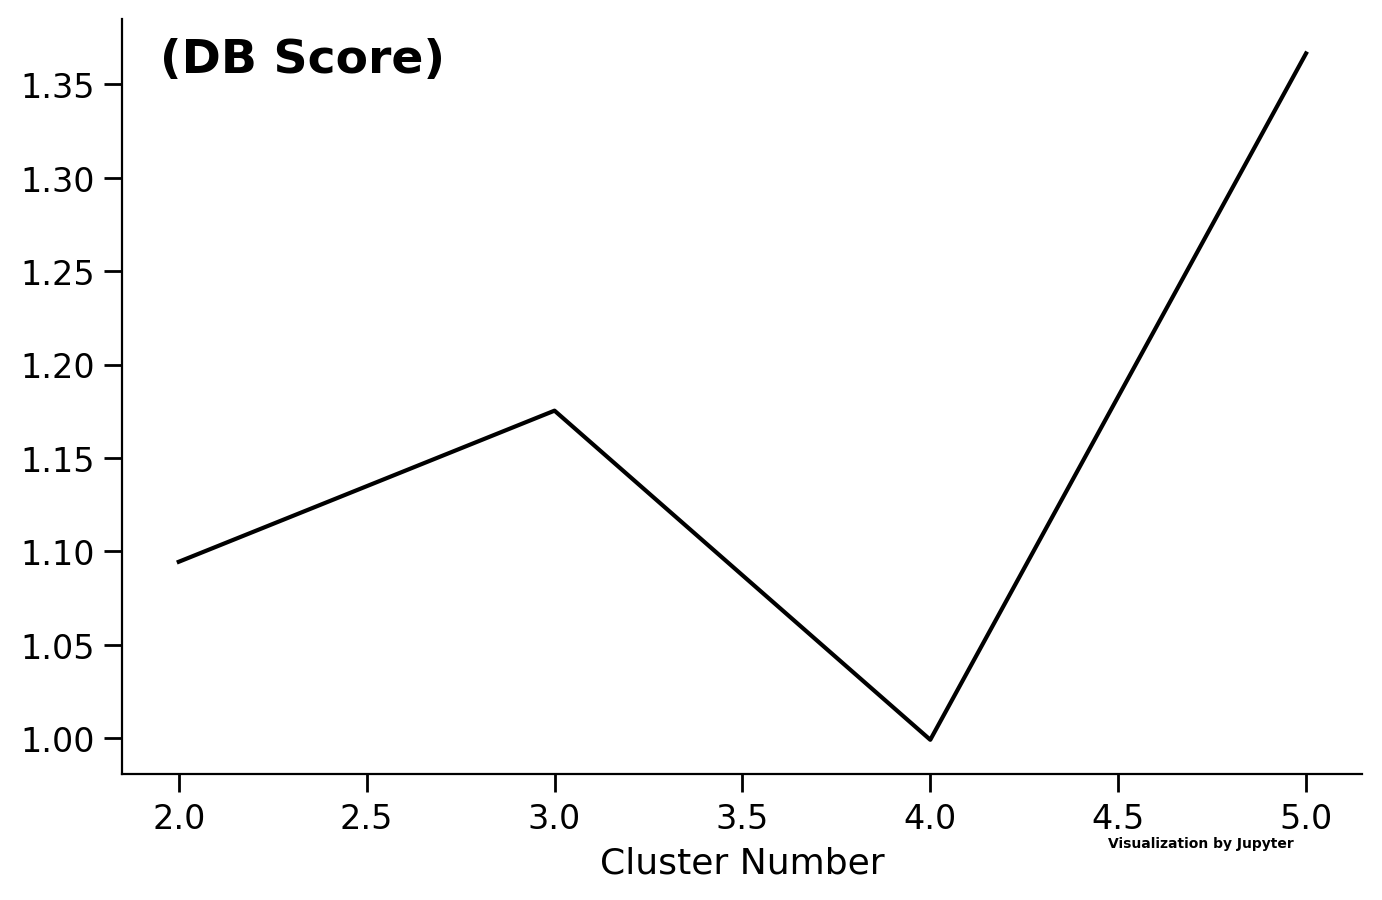

In [19]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics
silhouette_score=[]
calinski_harabasz_score=[]
davies_bouldin_score=[]
for n_clusters in range(2,6):
    SC = SpectralClustering(n_clusters=n_clusters,
                            affinity='precomputed',
                            eigen_solver='arpack',
                            random_state=0,
                            assign_labels='kmeans')
    clustering = SC.fit(affinity_matrix)
    silhouette_score.append(metrics.silhouette_score(affinity_matrix,clustering.labels_,metric='euclidean'))
    calinski_harabasz_score.append(metrics.calinski_harabasz_score(affinity_matrix,clustering.labels_))
    davies_bouldin_score.append(metrics.davies_bouldin_score(affinity_matrix,clustering.labels_))

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),silhouette_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.6,.93,'(Silhouette Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),calinski_harabasz_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(CH Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),davies_bouldin_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(DB Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

In [11]:
from sklearn.cluster import SpectralClustering
n_clusters = 3
SC = SpectralClustering(n_clusters=n_clusters,
                        affinity='precomputed',
                        eigen_solver='arpack',
                        random_state=0,
                        assign_labels='kmeans')
clustering = SC.fit(affinity_matrix)
clusters=[[] for _ in range(n_clusters)]
for i,road in enumerate(road_zip.keys()):
    label=clustering.labels_[i]
    clusters[label].append(road)
for i,cluster in enumerate(clusters):
    print(f"第{i}类元素个数: ",len(cluster))

第0类元素个数:  787
第1类元素个数:  762
第2类元素个数:  96


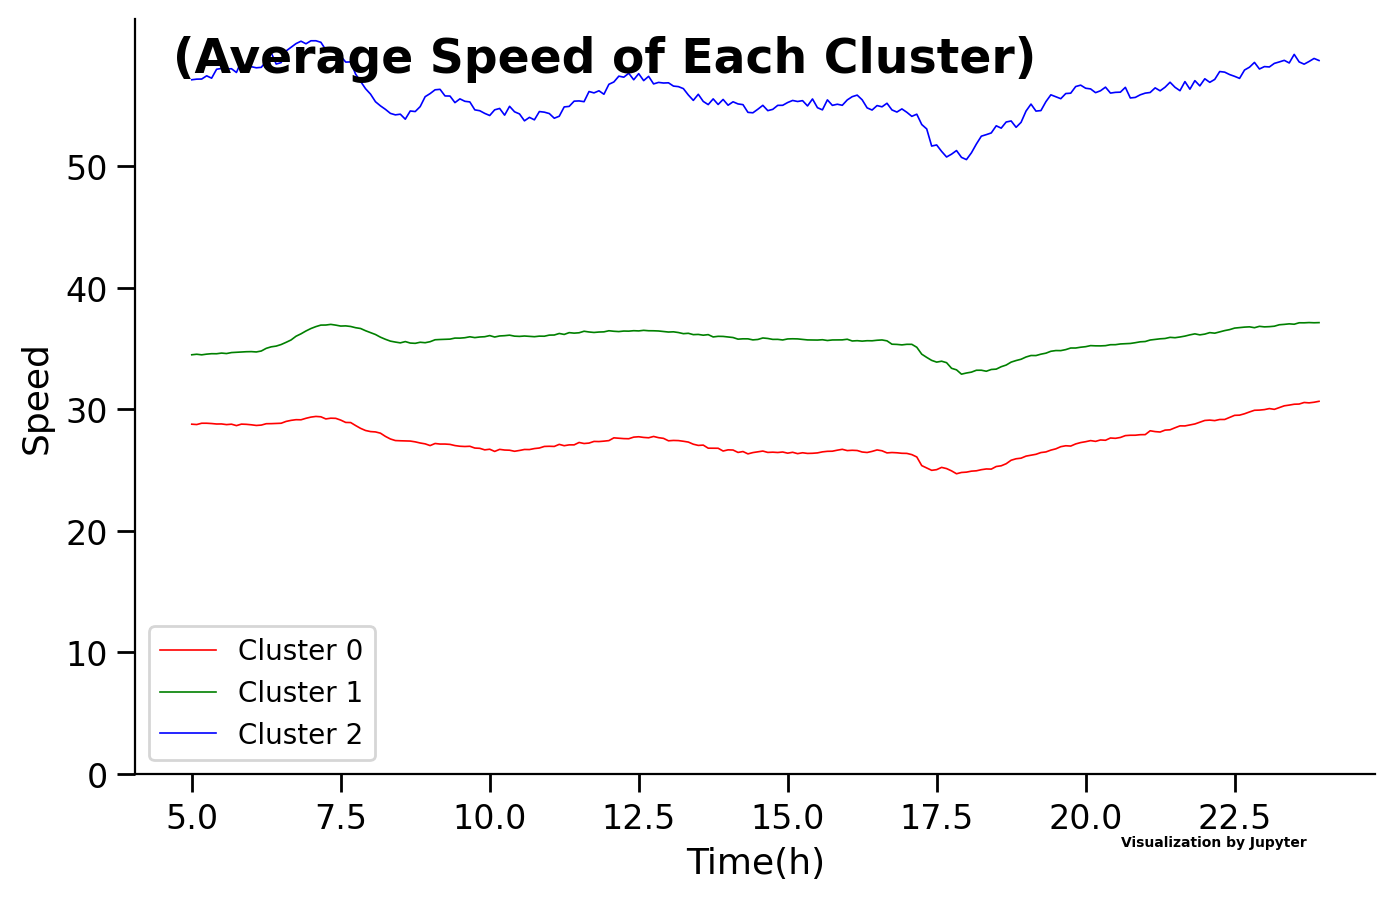

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
colors=['r','g','b','y']
curve={_:0 for _ in range(len(clusters))}
for no in range(len(clusters)):
    for road in clusters[no]:
        speed_seq=road_zip[road][:,:,1]
        speed_seq=np.mean(speed_seq,axis=0)
        curve[no]+=speed_seq
    curve[no]=curve[no]/len(clusters[no])
    label = [(i*5)/60+5 for i in range(len(curve[no]))]
    ax.plot(label, curve[no], color=colors[no], label=f'Cluster {no}', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(f'Speed',fontsize=13)
ax.set_xlabel('Time(h)',fontsize=13)
ax.set_yticks([i*10 for i in range(6)])
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,f'(Average Speed of Each Cluster)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
ax.legend()
fig.show()

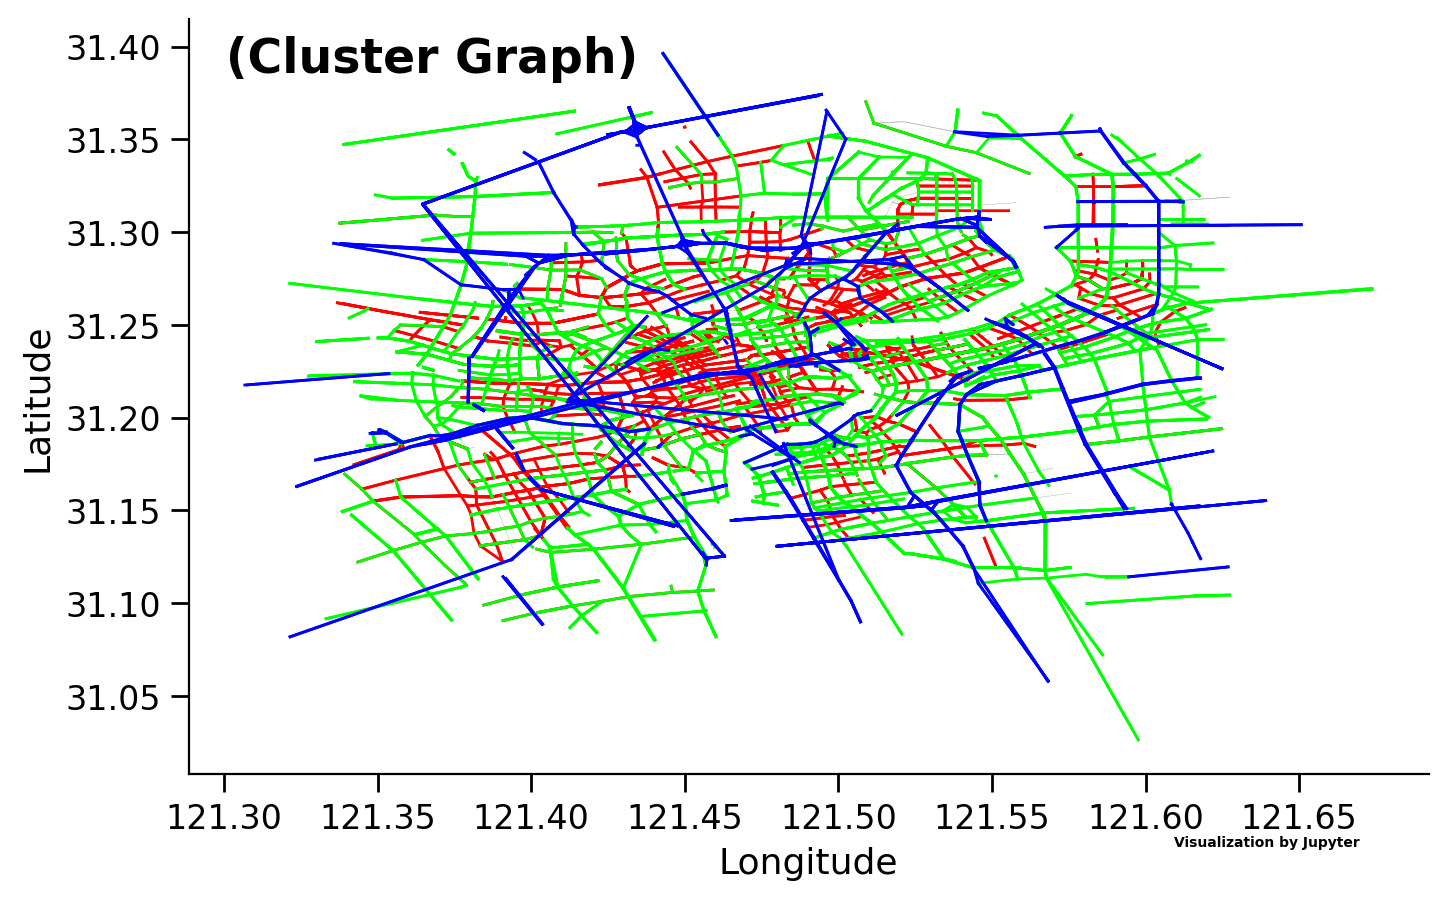

In [26]:
import matplotlib.pyplot as plt
# colors=['r','g','b','y','pink','brown','orange','black']
colors=[(1,0,0,1),(0,1,0,1),(0,0,1,1),(0.5,0.5,0,1)]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='grey',linewidth=.1)
        
for no in range(len(clusters)):
    for road in clusters[no]:
        if road not in road_edges:
            continue
        edges=road_edges[road]
        for edge in edges:
            a=edge[0]
            b=edge[1]
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=colors[no],linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Cluster Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

In [50]:
import json
ref=node_dict
data=[]
for no in range(len(clusters)):
    for road in clusters[no]:
        if road not in road_edges:
            continue
        edges=road_edges[road]
        for edge in edges:
            vi=edge[0]
            vj=edge[1]
            edge_msg={}
            edge_msg['color'] = colors[no]
            edge_msg['path'] = [[float(ref[vi][0]), float(ref[vi][1])],[float(ref[vj][0]),float(ref[vj][1])]]
            data.append(edge_msg)
json = json.dumps(data, ensure_ascii=False)
with open('../data/clusters.json','w') as f:
    f.write(json)

In [51]:
import panel as pn
import pydeck as pdk
import pandas as pd
import pandas as pd
from math import acos,cos,sin
pn.extension('deckgl')

MAPBOX_KEY = "KEY"

coord = [121.4382274,31.2265448]
r = 15
data = pd.read_json('../data/clusters.json')
drop_list = []

json_spec = {
    "initialViewState": {
        "bearing": -27.36,
        "latitude": 31.210428,
        "longitude": 121.475698,
        "maxZoom": 15,
        "minZoom": 5,
        "pitch": 40.5,
        "zoom": 11
    },
    "layers": [{
        "@@type": "PathLayer",
        "data": data,
        "widthScale": 10,
        "getPath": "@@=path",
        "getWidth" : 5,
        "getColor" : "@@=[255 * color[0],255 * color[1],255 * color[2]]",
        "pickable": True
    }],
    # "mapStyle": "mapbox://styles/mapbox/dark-v9",
    "views": [
        {"@@type": "MapView", "controller": True,}
    ]
}

deck_gl = pn.pane.DeckGL(json_spec, mapbox_api_key=MAPBOX_KEY, sizing_mode='stretch_width', height=600)

deck_gl.save("../img/cluster.html")

deck_gl

DeckGL(dict, height=600, mapbox_api_key='pk.eyJ1Ijoia29uZ2xpbmdodW..., sizing_mode='stretch_width')

# 关联关系

In [11]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
series_dict={}
for i,key in enumerate(road_zip.keys()):
    series_dict[key]=data[i][0] #因为数据量太大，只取第一天的

## Inverse normal transformation

In [12]:
from scipy.stats import norm
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]
bar = ProgressBar(widgets=widgets, maxval=len(series_dict)).start()

INT_dict={}
for i,label in enumerate(series_dict.keys()):
    top=sorted(series_dict[label])
    INT=[norm.ppf((top.index(i)+1-0.375)/(len(top)-0.75+1)) for i in series_dict[label]]
    INT_dict[label]=INT
    bar.update(i)
bar.finish()

Progress: 100% |##############| Elapsed Time: 0:00:52 Time: 0:00:52  31.26  B/s


In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
def print_curve(data):
    x = np.arange(len(data))
    y=data
    plt.plot(x, y, label="serise")
    plt.xlabel("time")
    plt.ylabel("num")
    plt.legend()
    plt.show()
def draw_distribute(data):
    tensor=np.array(data)
    plt.hist(tensor)
    plt.xlabel("value")
    plt.ylabel("fequence")
    plt.show()

('沪南公路', '从沪南路跨线桥到沪南公路东口')


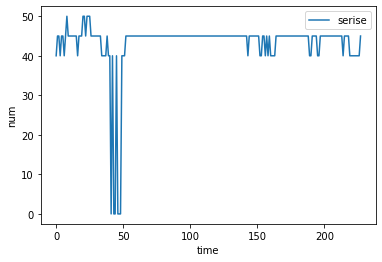

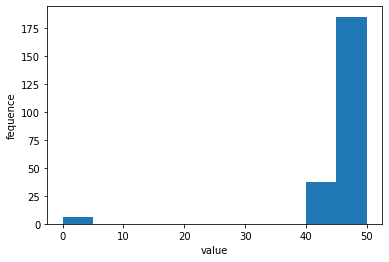

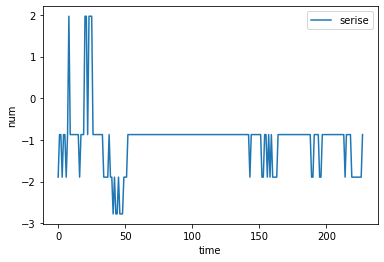

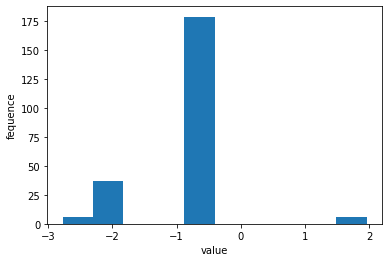

In [15]:
print(list(series_dict.keys())[0])
print_curve(series_dict[list(series_dict.keys())[0]])
draw_distribute(series_dict[list(series_dict.keys())[0]])
print_curve(INT_dict[list(INT_dict.keys())[0]])
draw_distribute(INT_dict[list(INT_dict.keys())[0]])

## Symbolic aggregate approximation

Progress: 100% |##############| Elapsed Time: 0:00:00 Time: 0:00:00   5.14 kB/s


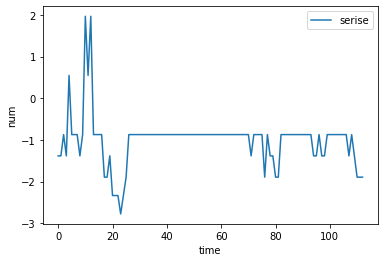

In [27]:
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]
bar = ProgressBar(widgets=widgets, maxval=len(series_dict)).start()

PAA_dict={}
size=2
for i,label in enumerate(INT_dict.keys()):
    PAA=[sum(INT_dict[label][i:i+size])/len(INT_dict[label][i:i+size]) for i in range(0,len(INT_dict[label])-size,size)]
    PAA_dict[label]=PAA
    bar.update(i)
bar.finish()
print_curve(PAA_dict[list(PAA_dict.keys())[0]])

In [28]:
symbol_dict={}
size=50
for label in PAA_dict:
    symbol=[chr(ord('a')+int(norm.cdf(i)*size)) for i in PAA_dict[label]]
    symbol_dict[label]=''.join(symbol)

In [29]:
symbol_dict[list(symbol_dict.keys())[0]]

'eeje\x84jjjej\x91\x84\x91jjjjbbeaaaaabjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjejjjjbjeebbjjjjjjjjjjjjeejeejjjjjjjjejebbb'

In [30]:
baskets=[]
btm='a'
top=chr(ord('a')+size-1)
for t in range(len(symbol_dict[list(series_dict.keys())[0]])):
    basket=[]
    for label in symbol_dict:
        if symbol_dict[label][t]==btm or symbol_dict[label][t]==top:
            basket.append((label,symbol_dict[label][t]))
    baskets.append(basket)
baskets[0]

[(('张杨北路', '从港华路到金桥路'), 'a'),
 (('日樱北路', '从港澳路到韩城路'), 'a'),
 (('航津路', '从航津路东口到浦东北路'), 'a'),
 (('富特北路', '从富特中路到港九路'), 'a'),
 (('富特北路', '从港九路到富特中路'), 'a'),
 (('永泰路', '从东泰林路到三新路'), 'a'),
 (('三鲁公路', '从Ｓ２０外环高速出入口到丰南路'), 'a'),
 (('新镇路', '从漕宝路到顾戴路'), 'a'),
 (('沪南路', '从沪南路跨线桥到龙阳路'), '\x92'),
 (('康桥路', '从外环罗山路立交桥到东泰林路'), 'a'),
 (('莲溪路', '从华夏西路到高科西路'), 'a'),
 (('金科南路', '从康桥路到华夏中路'), 'a'),
 (('张江路', '从华夏中路到龙东大道'), 'a'),
 (('高科西路', '从罗山路到杨高南路'), '\x92'),
 (('黑松路', '从蓝天路到黑松路南口'), 'a'),
 (('锦绣东路', '从罗山路到金桥路'), 'a'),
 (('锦绣东路', '从金桥路到罗山路'), 'a'),
 (('花木路', '从杨高南路到罗山路'), 'a'),
 (('花木路', '从罗山路到杨高南路'), 'a'),
 (('云山路', '从云山路南口到浦东大道'), 'a'),
 (('白桦路', '从碧云路到锦绣东路'), 'a'),
 (('碧波路', '从高科中路到科苑路'), 'a'),
 (('碧波路', '从科苑路到高科中路'), 'a'),
 (('江湾城路', '从殷高东路到江湾城路北口'), 'a'),
 (('江湾城路', '从江湾城路北口到殷高东路'), 'a'),
 (('江东路', '从港城路到江心沙路'), 'a'),
 (('杨高南路', '从杨高路下立交到上南路'), '\x92'),
 (('丁香路', '从锦绣路到锦康路'), 'a'),
 (('民生路', '从锦绣路到浦东大道'), 'a'),
 (('迎春路', '从政环路到丁香路'), 'a'),
 (('迎春路', '从丁香路到政环路'), 'a'),
 (('张杨路', '从金桥路到浦明路'), '\x92'

## Apriori

In [42]:
from apyori import apriori
results=list(apriori(transactions=baskets,
                     min_support=0.55,
                     min_lift=0.1,
                     use_colnames=False))
results

[RelationRecord(items=frozenset({(('上浦路', '从济阳路到上浦路东口'), 'a')}), support=0.7079646017699115, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({(('上浦路', '从济阳路到上浦路东口'), 'a')}), confidence=0.7079646017699115, lift=1.0)]),
 RelationRecord(items=frozenset({(('东泰路', '从世纪大道到东昌路'), 'a')}), support=0.9026548672566371, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({(('东泰路', '从世纪大道到东昌路'), 'a')}), confidence=0.9026548672566371, lift=1.0)]),
 RelationRecord(items=frozenset({(('临沂路', '从东方路到龙阳路'), 'a')}), support=0.5663716814159292, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({(('临沂路', '从东方路到龙阳路'), 'a')}), confidence=0.5663716814159292, lift=1.0)]),
 RelationRecord(items=frozenset({(('临青路', '从杨树浦路到长阳路'), 'a')}), support=0.584070796460177, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({(('临青路', '从杨树浦路到长阳路'), 'a')}), confidence=0.584070796460177, lift=1.0)]),
 Relat

In [50]:
max_lift=0
min_lift=1
for item in results:
    for s in item.ordered_statistics:
        if s.lift>max_lift:
            max_lift=s.lift
        if s.lift<min_lift:
            min_lift=s.lift
print(min_lift,max_lift)

0.9527337761880429 1.7384615384615385


In [55]:
import csv
from matplotlib import cm,colors
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]
bar = ProgressBar(widgets=widgets, maxval=len(results)).start()
ref=node_dict
maxium,minium=1.4,min_lift
cmap = cm.get_cmap('seismic', 10)
with open('../data/arcmap.csv','w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['lng_s','lat_s','lng_t','lat_t','weight','r','g','b'])
    for i,item in enumerate(results):
        for s in item.ordered_statistics:
            for base in s.items_base:
                for add in s.items_add:
                    if base[0] not in road_edges or add[0] not in road_edges:
                        continue
                    base_road=road_edges[base[0]]
                    add_road=road_edges[add[0]]
                    
                    base_edge=base_road[int(len(base_road)/2)]
                    add_edge=add_road[int(len(add_road)/2)]
                    
                    base_location=((float(ref[base_edge[0]][0])+float(ref[base_edge[1]][0]))/2, (float(ref[base_edge[0]][1])+float(ref[base_edge[1]][1]))/2)
                    add_location=((float(ref[add_edge[0]][0])+float(ref[add_edge[1]][0]))/2, (float(ref[add_edge[0]][1])+float(ref[add_edge[1]][1]))/2)
                    
                    color = cmap((s.lift-minium)/(maxium-minium))
                    
                    csv_writer.writerow([base_location[0],base_location[1],
                                         add_location[0],add_location[1],
                                         s.lift,
                                         color[0],color[1],color[2]])
        bar.update(i)
    bar.finish()
    f.close()

Progress: 100% |##############| Elapsed Time: 0:00:53 Time: 0:00:53  96.42  B/s


In [ ]:
import panel as pn
import pydeck as pdk
import pandas as pd
pn.extension('deckgl')

MAPBOX_KEY = "KEY"

df = pd.read_csv("../data/arcmap.csv")

json_spec = {
    "initialViewState": {
        "bearing": -27.36,
        "latitude": 31.210428,
        "longitude": 121.475698,
        "maxZoom": 15,
        "minZoom": 5,
        "pitch": 40.5,
        "zoom": 11
    },
    "layers": [{
        "@@type": "ArcLayer",
        "data": df,
        "getWidth": "3",
        "getSourcePosition" : "@@=[lng_s, lat_s]",
        "getTargetPosition" : "@@=[lng_t, lat_t]",
        "getTilt" : 15,
        "getSourceColor" : "@@=[255 * r,255 * g,255 * b]",
        "getTargetColor" : "@@=[255 * r,255 * g,255 * b]",
        "pickable": True,
        "autoHighlight" : True
    }],
    #"mapStyle": "mapbox://styles/mapbox/dark-v9",
    "views": [
        {"@@type": "MapView", "controller": True}
    ]
}

deck_gl = pn.pane.DeckGL(json_spec, mapbox_api_key=MAPBOX_KEY, sizing_mode='stretch_width', height=600)

deck_gl.save("../img/association.html")

deck_gl